In [1]:
import torch
import torchvision
from torchvision import transforms 
import torchaudio
from torch import nn
from torch import optim
from torch.nn import functional as f
from torch.nn import functional as F
from torchviz import make_dot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
np.random.seed(seed:=69)
torch.manual_seed(seed)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

C:\ProgramData\Miniconda3\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\ProgramData\Miniconda3\lib\site-packages\torchaudio\backend\utils.py:63: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
x = torch.ones(2, 2, requires_grad=True)
x

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

In [3]:
y = x + 2
y

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)

In [4]:
y.grad_fn

In [5]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # max pool over a (2, 2) kernel
        x = f.max_pool2d(f.relu(self.conv1(x)), (2, 2))
        # if the size is a square you can specify a single number instead
        x = f.max_pool2d(f.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dims except batch dim
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [6]:
net = Net()
net.to(device)
params = list(net.parameters())
param_size = len(params)

print(f'param size: {param_size}\nparam shape: {params[0].size()}')

param size: 10
param shape: torch.Size([6, 1, 3, 3])


In [7]:
input = torch.randn(1, 1, 32, 32).to(device)
out = net(input)
out

tensor([[ 0.0206, -0.0915,  0.0910,  0.0920,  0.1092,  0.0552, -0.0146,  0.0892,
          0.0047, -0.0092]], device='cuda:0', grad_fn=<AddmmBackward>)

In [8]:
net.zero_grad()
out.backward(torch.randn(1, 10).to(device))

In [9]:
# torch.nn only supports mini-batches. The entire torch.nn package only supports inputs that are a mini-batch of samples, and not a single sample.
# For example, nn.Conv2d will take in a 4D Tensor of nSamples x nChannels x Height x Width.
# If you have a single sample, just use input.unsqueeze(0) to add a fake batch dimension.

In [10]:
output = net(input)
target = torch.randn(10).to(device) # dummy target
target = target.view(1, -1)
criterion = nn.MSELoss()
loss = criterion(output, target)
print(loss)

tensor(0.5434, device='cuda:0', grad_fn=<MseLossBackward>)


In [11]:
print(loss.grad_fn)

In [12]:
net.zero_grad()     # zeroes the gradient buffers of all parameters
print(f'conv1.bias.grad before backward: {net.conv1.bias.grad}')
loss.backward()
print(f'conv1.bias.grad after: {net.conv1.bias.grad}')

conv1.bias.grad before backward: tensor([0., 0., 0., 0., 0., 0.], device='cuda:0')
conv1.bias.grad after: tensor([-0.0019,  0.0036,  0.0076, -0.0056,  0.0042,  0.0076], device='cuda:0')


In [13]:
learning_rate = 0.01
# manual calculation:
# for f in net.parameters():
#     f.data.sub_(f.grad.data * learning_rate)

# for prepackaged calculation:
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# put in training loop:
optimizer.zero_grad()
output = net(input)
loss = criterion(output, target) # criterion is a loss function
loss.backward()
optimizer.step()

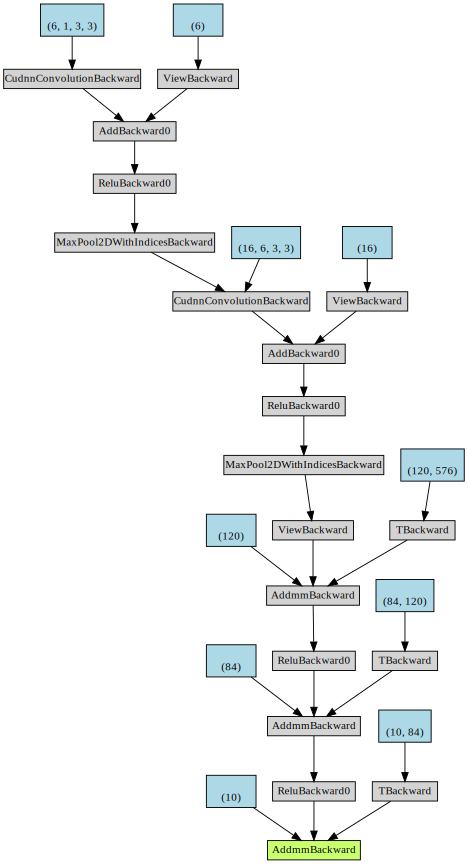

In [14]:
make_dot(output)

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((.5,.5,.5), (.5,.5,.5))])

In [16]:
root = 'E:\Vision'
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [17]:
def imshow(img):
    img = img / 2 + .5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [18]:
# get a random training img
dataiter = iter(trainloader)
data = dataiter.next()
images, labels = data[0].to(device), data[1].to(device)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
running_loss = 0
for epoch in range(2):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        # forward, backward, optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print stats
        running_loss += loss.item()
        steps = 2000
        if i % steps == steps - 1: # print every 2000 minibatches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / steps))
            running_loss = 0.
print('finished training')

In [ ]:
PATH = 'E:\Models\pytorch_fun\poggers.pt'
torch.save(net.state_dict(), PATH)

In [ ]:
with torch.no_grad():
    loss = 0
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)

In [ ]:
dataiter = iter(testloader)
data = dataiter.next()
inputs, labels = data[0].to(device), data[1].to(device)

In [ ]:
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
# this part is completely unnecessary, but it shows you how to load a model
net = Net()
net.to(device)
net.load_state_dict(torch.load(PATH))
net.to(device)

In [ ]:
outputs = net(images)

In [ ]:
# The outputs are energies for the 10 classes. 
# The higher the energy for a class, the more the network thinks that the image is of the particular class. 
# So, let’s get the index of the highest energy
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [ ]:
# now evaluate percent accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the {total} test images: %d %%' % (100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))